# Preprocessing Ablation Data
---
> Preprocessing amnioserosa ablation movies from Hara et al. 2016

# Hara Ablation Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx, pandas as pd
from simgnn.datautils import simple_moving_average,load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, HaraMovies, CellData
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


In [347]:
import glob
from simgnn.hara import get_cell_colormap, read_tiff_stack

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import label_bw_stack, extract_graph

In [463]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [481]:
recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


In [489]:
last_frame_masks = [path.basename(img_name) for img_name in glob.glob(path.join(ablmov_basepath,'frames_masks','*.tif'))]
long_mov_names = recoil_df[recoil_df.AblationFrame>49][['Main folder', 'embryo','Edge ID']]

needs_mask = []
for k in range(len(long_mov_names)):
    mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_mask.tif'
    if mov_name not in last_frame_masks:
        needs_mask.append(k)
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = False
    else:
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = True

long_mov_names.to_csv('/Users/muratshagirov/Desktop/movies_run_avrg/mask_progress.csv')

In [495]:
long_mov_names[(long_mov_names.HasMask)]

,Main folder,embryo,Edge ID,HasMask
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,True
2,140411_Dacat_recoil,sample5,1,True
9,140429_amni_ablation,sample4,1,True
10,140429_amni_ablation,sample4,2,True
11,140429_amni_ablation,sample4,3,True
...,...,...,...,...
162,141212_Dacat_recoil,sample5,1,True
169,141213_Dacat_recoil,sample5,1,True
170,141213_Dacat_recoil,sample6,1,True
172,141213_Dacat_recoil,sample8,1,True


140606_DaCat_recoil_sample3_2.tif
140606_DaCat_recoil_sample3_2_nodes.csv
Image stack shape: (100, 512, 512) -- trim boundaries: False
[171.5, 329.5]


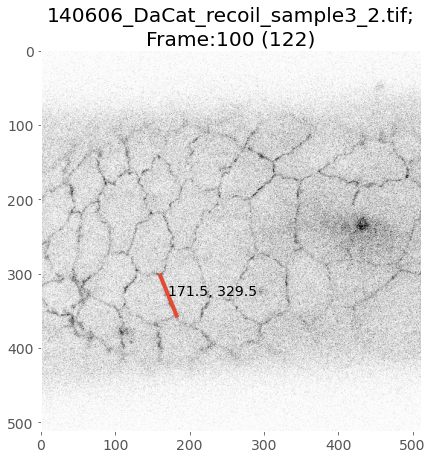

In [497]:
k=needs_mask[0]
mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'.tif'
print(mov_name)
track_csv = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_nodes.csv'
print(track_csv)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',mov_name),trim_bound=False)
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',track_csv))
edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print(edge_pos)

plt.imshow(img[-1],cmap='gray_r');plt.grid(False);
plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]], lw=4);
plt.text(edge_pos[0],edge_pos[1],f'{edge_pos[0]:g}, {edge_pos[1]:g}')
plt.title(f'{mov_name};\nFrame:{node_tracking.iloc[-1].frames:n} ({node_tracking.iloc[-1].t:n})');

- Extract Graphs from Amnioserosa Movies

In [29]:
# root_dir = 'simgnn_data/hara_movies/raw/'
# PROCESS_HARA_MOVIE = False # set to true to process Hara AS tissue movies

# if PROCESS_HARA_MOVIE:
#     for bw_img in seg:
#         edges_index, node2cell_index, v_pos = extract_graph(seg[bw_img], label_bw_stack(seg[bw_img])[0])
#         edge_lengths = np.sqrt(((v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:])**2).sum(axis=-1,keepdims=True))

#         dataDir = path.join(root_dir, bw_img)
#         mknewdir(dataDir);

#         write_array(path.join(dataDir, 'edges_index.npy'), edges_index)
#         write_array(path.join(dataDir, 'node2cell_index.npy'), node2cell_index)
#         write_array(path.join(dataDir, 'vtx_pos.npy'), v_pos)
#         write_array(path.join(dataDir, 'edge_Length.npy'), edge_lengths)

# Node Tracking with Napari

**Note** : Restart the jupyter kernel in an env w/ napari !

In [1]:
from skimage import data,io
import napari, numpy as np, glob, pandas as pd
from os import path

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import read_tiff_stack, get_roi_cell_labels, get_cell_colormap

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

In [2]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [3]:
sample_name = '140429_amni_ablation_sample4_1'

save_dir = path.join(data_base_path,'raw',sample_name)
mknewdir(save_dir)
print(sample_name,'\n---\nResults will be saved in\n\t',save_dir,'\n')

img = read_tiff_stack(path.join(ablmov_basepath,'movies',sample_name+'.tif'),trim_bound=False)
last_mask = io.imread(path.join(ablmov_basepath,'frames_masks',sample_name+'_mask.tif'),as_gray=True)

n_frames = img.shape[0]
t = list(reversed(range(n_frames-1,-1,-10)))
img = img[t] # re-sample frames for 10s frame rate

# Hara et al. ablated edge vertices: fiducials
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',sample_name+'_nodes.csv'))
node_tracking['frames'] = node_tracking['frames']-1 # frames start from 0


# in case if not all frames are tracked
t_frames = [node_tracking[node_tracking['frames']==k].index.values[0]
            for k in reversed(range(n_frames-1,node_tracking['frames'].iloc[0]-1,-10))]
node_tracking = node_tracking.loc[t_frames,:] # re-sample frames for 10s frame rate
node_tracking['frames'] = (node_tracking['frames'] - t[0])/10

edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print('Edge pos (x,y,t=-1):',edge_pos)
# Reshape dimensions for napari
abltd_verts = node_tracking.iloc[:,[0,3,2,0,5,4]].values.reshape(-1,2,3)
# order of the variables for napari
node_tracking.iloc[:,[0,3,2,0,5,4]]

Directory already exists.
140429_amni_ablation_sample4_1 
---
Results will be saved in
	 ./simgnn_data/hara_ablation/raw/140429_amni_ablation_sample4_1 

Image stack shape: (54, 512, 512) -- trim boundaries: False
Edge pos (x,y,t=-1): [166.83333333333334, 251.83333333333334]


,frames,y1,x1,frames,y2,x2
3,0.0,241.500000,140.833333,0.0,267.500000,187.833333
13,1.0,242.500000,140.833333,1.0,267.500000,187.833333
23,2.0,242.833333,142.833333,2.0,265.166667,188.166667
33,3.0,242.166667,145.833333,3.0,263.833333,188.500000
43,4.0,242.166667,146.500000,4.0,263.166667,187.500000
53,5.0,241.500000,146.500000,5.0,262.166667,187.166667


In [11]:
Ls_new, Cpos_new = get_roi_cell_labels(last_mask, node_tracking.iloc[-1,[2,3]].values, node_tracking.iloc[-1,[4,5]].values,s=1.5)

In [ ]:
def get_node_locations_bw(img,):
    '''
    Arg-s:
        - img : binary  of cell boundaries with pixel values in {0,255} (0:background, 255: foreground).
    '''

In [12]:
# 


In [13]:
# 2D XY grid for images
Xgrid, Ygrid = np.meshgrid(np.arange(0,last_mask.shape[1]), np.arange(0,last_mask.shape[0]) )
ccj_x, ccj_y = Xgrid[ last_mask != 0].ravel(), Ygrid[ last_mask != 0].ravel()

last_mask_roi = np.zeros_like(last_mask)
v0_pos_guess = []
for xi,yi in zip(ccj_x, ccj_y):
    if len([li for li in np.unique(Ls_new[yi-1:yi+2,xi-1:xi+2]) if li!=0])<1:
        continue
    last_mask_roi[yi,xi] = 255
    if (last_mask[yi-1:yi+2,xi-1:xi+2]/255).sum()<4:
        continue
    v0_pos_guess.append([xi,yi])

v0_mask = np.ones((len(v0_pos_guess),),dtype=np.int32)
v0_pos_guess = np.array(v0_pos_guess)
v0_pos_cortd = []
for k,vi_pos in enumerate(v0_pos_guess):
    if v0_mask[k]<1:
        continue
    v0_pos_cortd.append(vi_pos)
    v0_mask[np.sum((v0_pos_guess - vi_pos)**2,axis=1)<4] = 0

v0_pos_cortd = np.stack(v0_pos_cortd,axis=0)

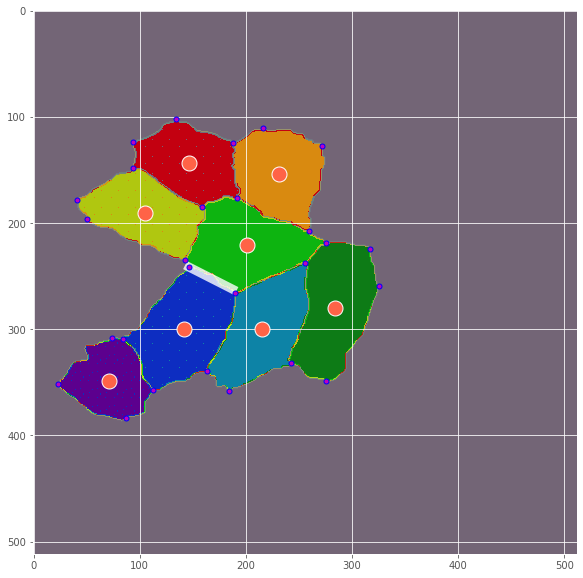

In [14]:
plt.figure(figsize=[10,10])
cmap, norm = get_cell_colormap(Ls_new.max()+3)
plt.imshow(Ls_new, cmap=cmap,norm=norm)
plt.imshow(last_mask_roi,alpha=.2)
plt.plot(Cpos_new[:,0],Cpos_new[:,1],'o',c='tomato',mec='w',ms=15)
plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]],'-w',lw=9,alpha=.8)
plt.plot(v0_pos_cortd[:,0],v0_pos_cortd[:,1],'mo',mec='b',ms=5)
plt.show()

In [5]:
viewer = napari.view_image(img,name='movie')
mask_layer = viewer.add_image(last_mask,name='mask',colormap='green',blending='additive',opacity=.5)
abltd_v_layer = viewer.add_shapes(abltd_verts,name='abltn',shape_type='line', edge_width=5,edge_color='red',blending='additive',opacity=.5)
v0s_layer = viewer.add_points(ndim=3,name='v0s',size=3,face_color='m',edge_color='g')

In [8]:
colors= plt.cm.RdYlGn(np.linspace(0,1,v0s_layer.data.shape[0]))
verts_layers = {}
for k in range(v0s_layer.data.shape[0]):
    verts_layers[k] = viewer.add_points([v0s_layer.data[k]],ndim=3,name=f'v{k}',size=3,
                                        face_color=colors[k],edge_color=colors[k],
                                        properties={'label':[k]},
                                        text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'})

Make all tracked vertices visible and copy their positions

In [9]:
# for k in verts_layers:
#     verts_layers[k].visible=1

verts_pos = [ verts_layers[k].data.copy() for k in verts_layers]
verts_pos

[array([[  0.        , 224.37596449, 262.68738506],
        [  1.        , 225.37527743, 263.28188774],
        [  2.        , 224.61834687, 262.43034086],
        [  3.        , 224.80757951, 261.29494502],
        [  4.        , 228.78146496, 260.91647974]]),
 array([[  0.        , 297.57566129, 252.91152979],
        [  1.        , 296.02001998, 252.61726006],
        [  2.        , 298.74107708, 251.41679369],
        [  3.        , 300.42173   , 252.21710461],
        [  4.        , 302.98272492, 253.81772643]]),
 array([[  0.        , 327.1416626 , 219.53056056],
        [  1.        , 325.63152372, 219.96457486],
        [  2.        , 327.07208336, 218.44398413],
        [  3.        , 326.51186572, 218.92417068],
        [  4.        , 331.08164516, 221.82986832]]),
 array([[  0.        , 320.70390425, 272.22480484],
        [  1.        , 321.20917714, 272.66704078],
        [  2.        , 324.04587937, 273.1603803 ],
        [  3.        , 329.84261869, 272.66704078],
      

In [97]:
# colors= plt.cm.RdYlGn(np.linspace(0,1,len(verts_pos)))
# verts_layers = {}
# for k in range(len(verts_pos)):
#     verts_layers[k] = viewer.add_points(verts_pos[k],ndim=3,name=f'v{k}',properties={'label':k*np.ones((6,),dtype=np.int_)},
#                                         text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'},
#                                         size=3,face_color=colors[k],edge_color=colors[k])

In [11]:
vtx_pos = np.transpose(np.stack([v_t[:,[2,1]] for v_t in verts_pos],axis=0), (1,0,2))

edges_index = np.array([[0,1],[0,9],[0,8],
                        [1,2],[1,3],
                        [2,11],[3,4],[4,5],
                        [5,6],[5,16],
                        [6,7],[6,13],[7,8],
                        [9,10],[9,17],
                        [10,12],[10,11],
                        [12,19],[13,14],[14,15],[15,16],
                        [17,18],[18,19] ]).T.astype(np.int64)

node2cell_index = np.array([[0,0],[1,0],[10,0],[9,0],[2,0],[11,0], 
                            [0,1],[1,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],
                            [5,2],[6,2],[13,2],[14,2],[15,2],[16,2],
                            [9,3],[10,3],[12,3],[17,3],[18,3],[19,3] ]).T.astype(np.int64)

In [12]:
# Save frames
write_array(path.join(save_dir,'frames.npy'), np.array(t) )

#vert positions array: #frames, #verts, #dims(==2)
write_array(path.join(save_dir,'vtx_pos.npy'), vtx_pos )

# edges index 2xN_edges
write_array(path.join(save_dir,'edges_index.npy'), edges_index )

# nodes to cells edges
write_array(path.join(save_dir,'node2cell_index.npy'), node2cell_index )

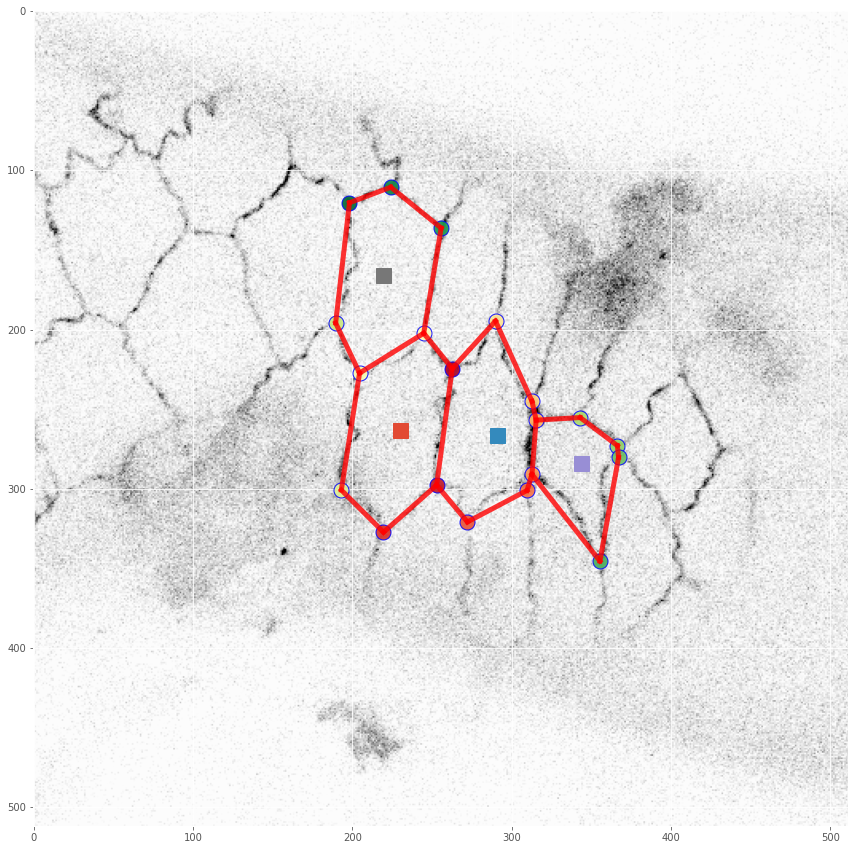

In [13]:
plt.figure(figsize=[15,15])
t_plt = 0
plt.imshow(img[t_plt],cmap='gray_r')

for k,vk in enumerate( vtx_pos[t_plt]):
    plt.plot(vk[0],vk[1],'o',c=colors[k],mec='b',ms=15,alpha=.9)
for e in edges_index.T:
    plt.plot(vtx_pos[t_plt][e,0],vtx_pos[t_plt][e,1],'r',lw=5,alpha=.8)
    
for ci in np.unique(node2cell_index[1]):
    ci_vk = node2cell_index[0,node2cell_index[1]==ci]
    ci_pos = vtx_pos[t_plt][ci_vk,:].mean(axis=0)
    plt.plot(ci_pos[0],ci_pos[1],'s',ms=15)